**Dataset Information: -**


1.   https://www.spectrumnews.org/news/researchers-publish-new-dataset-on-minimally-verbal-autistic-people/
2.   https://zenodo.org/record/5786860#.ZG0w_HZBw2w



**Installing files from Zenodo: -**


1.   pip install zenodo-get
2.   zenodo_get 10.5281/zenodo.5786860

(10.5281/zenodo.5786860 is the DOI of the database publication)




#Imports

In [1]:
%tensorflow_version 2.x  # this line is not required unless you are in a notebook
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio

In [4]:
from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio
import torch.nn.functional as F
from torch.nn import init
import torch
import torchvision
import torch.nn as nn

#Read and Prepare Dataset


In [7]:
path = "/content/drive/MyDrive/Colab DataSets/Person-wise Data/P08.xlsx"
df_original = pd.read_excel(path)
df_original.head()

#There are 6 classes of sounds in the dataset.
#The class label is categorical, and hence will be converted to a numeric Class ID later.
#E.g.: 0 = air conditioner, 1 = car horn, etc.

,Filename,Label
0,200818_1831_00-01-06.4--00-01-07.78.wav,delighted
1,200818_1831_00-01-07.82--00-01-08.31.wav,delighted
2,200818_1831_00-01-09.36--00-01-10.38.wav,delighted
3,200822_0836_00-33-34.17--00-33-36.79.wav,delighted
4,200822_0836_00-37-58.92--00-38-01.48.wav,delighted


Training Data: -
*   The features (X): Audio Paths
*   The target labels (y): Class Names

In [8]:
df_original.shape[0]

1460

In [9]:
df_original.Label.unique() #Print unique types of sound

array(['delighted', 'frustrated', 'request', 'selftalk', 'social'],
      dtype=object)

In [10]:
df_original['Label'].nunique() #Our dataset has 22 target variables/classes.

5

In [11]:
df_original['Label'].value_counts() #Number of datapoints available for each target variable

Label
frustrated    781
selftalk      503
social         93
request        44
delighted      39
Name: count, dtype: int64

In [12]:
#Convert Text to number notation for target variable (Categorical to numerical data)

df_original["classID"] = df_original['Label']
df_original['classID'].replace(['delighted', 'frustrated', 'request', 'selftalk', 'social'],
                        [0, 1, 2, 3, 4], inplace=True)


#Create new dataframe called 'df' with only two columns - Filename, classID.
df = df_original
df = df.drop(['Label'], axis=1)
df.head()

,Filename,classID
0,200818_1831_00-01-06.4--00-01-07.78.wav,0
1,200818_1831_00-01-07.82--00-01-08.31.wav,0
2,200818_1831_00-01-09.36--00-01-10.38.wav,0
3,200822_0836_00-33-34.17--00-33-36.79.wav,0
4,200822_0836_00-37-58.92--00-38-01.48.wav,0


In [13]:
df['classID'].value_counts() #Number of datapoints available for each target variable

classID
1    781
3    503
4     93
2     44
0     39
Name: count, dtype: int64

In [14]:
# Construct file path by concatenating fold and file name
df['relative_path'] = '/' + df['Filename'].astype(str)

# Take relevant columns
df = df[['relative_path', 'classID']]
df.head()

,relative_path,classID
0,/200818_1831_00-01-06.4--00-01-07.78.wav,0
1,/200818_1831_00-01-07.82--00-01-08.31.wav,0
2,/200818_1831_00-01-09.36--00-01-10.38.wav,0
3,/200822_0836_00-33-34.17--00-33-36.79.wav,0
4,/200822_0836_00-37-58.92--00-38-01.48.wav,0


#Audio Pre-processing

Audio data is memory intensive. So, we don’t want to read the entire dataset into memory all at once. Instead, we keep only the audio file names in our training data and perform pre-processing dynamically during runtime.

Then, at runtime, as we train the model one batch at a time, we will load the audio data for that batch and process it by applying a series of transforms to the audio. That way we keep audio data for only one batch in memory at a time.

In [15]:
#Random shuffle of rows.
df = df. sample(frac=1)
df.head()

,relative_path,classID
830,/200828_1835_00-02-21.19--00-02-23.58.wav,2
498,/210113_1909_00-12-31.03--00-12-32.32c.wav,1
27,/200908_1857_00-00-32.61--00-00-33.75c.wav,0
548,/210113_1909_00-14-27.13--00-14-27.79.wav,1
939,/200822_1131_00-12-56.26--00-12-56.97.wav,3


In [16]:
#Function to read and load the audio files in '.wav' format using Pytorch.
class AudioUtil():
  @staticmethod
  def open(audio_file):
    sig, sr = torchaudio.load(audio_file) # Load an audio file. Return the signal as a tensor and the sample rate
    return (sig, sr)


#Refer tutotial file for explaination about the following blocks of code: -
  def rechannel(aud, new_channel):
    sig, sr = aud
    if (sig.shape[0] == new_channel):
      return aud
    if (new_channel == 1):
      resig = sig[:1, :]
    else:
      resig = torch.cat([sig, sig])
    return ((resig, sr))

  def resample(aud, newsr):
    sig, sr = aud
    if (sr == newsr):
      return aud
    num_channels = sig.shape[0]
    resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
    if (num_channels > 1):
      retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
      resig = torch.cat([resig, retwo])
    return ((resig, newsr))

  def pad_trunc(aud, max_ms):
    sig, sr = aud
    num_rows, sig_len = sig.shape
    max_len = sr//1000 * max_ms
    if (sig_len > max_len):
      sig = sig[:,:max_len]
    elif (sig_len < max_len):
      pad_begin_len = random.randint(0, max_len - sig_len)
      pad_end_len = max_len - sig_len - pad_begin_len
      pad_begin = torch.zeros((num_rows, pad_begin_len))
      pad_end = torch.zeros((num_rows, pad_end_len))
      sig = torch.cat((pad_begin, sig, pad_end), 1)
    return (sig, sr)

  def time_shift(aud, shift_limit):
    sig,sr = aud
    _, sig_len = sig.shape
    shift_amt = int(random.random() * shift_limit * sig_len)
    return (sig.roll(shift_amt), sr)

  def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
    sig,sr = aud
    top_db = 80
    spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)
    spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
    return (spec)

  def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
    _, n_mels, n_steps = spec.shape
    mask_value = spec.mean()
    aug_spec = spec
    freq_mask_param = max_mask_pct * n_mels
    for _ in range(n_freq_masks):
      aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)
    time_mask_param = max_mask_pct * n_steps
    for _ in range(n_time_masks):
      aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)
    return aug_spec

#Define Custom Data Loader


To feed the data to a model with Pytorch, we need two objects:

*   A custom Dataset object that uses all the audio transforms to pre-process an audio file and prepare one data item at a time.
*   A built-in DataLoader object that uses the Dataset object to fetch individual data items and packages them into a batch of data.

In [17]:
class SoundDS(Dataset):
  def __init__(self, df, data_path):
    self.df = df
    self.data_path = str(data_path)
    self.duration = 4000
    self.sr = 44100
    self.channel = 2
    self.shift_pct = 0.4

  #Number of items in dataset
  def __len__(self):
    return len(self.df)


  #Get i'th item in dataset
  def __getitem__(self, idx):
    #Absolute file path of the audio file = audio directory + relative path
    audio_file = self.data_path + self.df.loc[idx, 'relative_path']
    #Get the Class ID
    class_id = self.df.loc[idx, 'classID']

    aud = AudioUtil.open(audio_file)
    """
    Some sounds have a higher sample rate, or fewer channels compared to the
    majority. So make all sounds have the same number of channels and same
    sample rate. Unless the sample rate is the same, the pad_trunc will still
    result in arrays of different lengths, even though the sound duration is
    the same.
    """
    reaud = AudioUtil.resample(aud, self.sr)
    rechan = AudioUtil.rechannel(reaud, self.channel)


    dur_aud = AudioUtil.pad_trunc(rechan, self.duration)
    shift_aud = AudioUtil.time_shift(dur_aud, self.shift_pct)
    sgram = AudioUtil.spectro_gram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
    aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

    return aug_sgram, class_id

#Prepare Batches of Data with the Data Loader

Load the Features and Labels from our Pandas dataframe and split it in an 80:20 ratio for training and validation. Then, use them to create the training and validation Data Loaders.

In [18]:
data_path = "/content/drive/MyDrive/Colab DataSets/Person-wise Data/P08"
myds = SoundDS(df, data_path)
#myds = SoundDS(df, path)

#Random split of 80:20 between training and validation
num_items = len(myds)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(myds, [num_train, num_val])

#Create training and validation data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False)

In [19]:
print(num_items, num_train, num_val)

1460 1168 292


In [20]:
type(train_dl)

torch.utils.data.dataloader.DataLoader

During training, the Data Loader will randomly fetch one batch of input features containing the list of audio file names and run the pre-processing audio transforms on each audio file. It will also fetch the corresponding target labels containing the class IDs. Thus it will output one batch of training data at a time, which can directly be fed as input to our DL model.



*   The audio from the file gets loaded into a Numpy array of shape (num_channels, num_samples). Most of the audio is sampled at 44.1kHz and is about 4 seconds in duration, resulting in 44,100 * 4 = 176,400 samples. If the audio has 1 channel, the shape of the array will be (1, 176400). Similarly, audio of 4 seconds duration with 2 channels and sampled at 48kHz will have 192,000 samples and a shape of (2, 192000).
*   Since the channels and sampling rates of each audio are different, the next two transforms resample the audio to a standard 44.1kHz and to a standard 2 channels.
*   Since some audio clips might be more or less than 4 seconds, we also standardize the audio duration to a fixed length of 4 seconds. Now arrays for all items have the same shape of (2, 176,400).
*   The Time Shift data augmentation now randomly shifts each audio sample forward or backward. The shapes are unchanged.
*   The augmented audio is now converted into a Mel Spectrogram, resulting in a shape of (num_channels, Mel freq_bands, time_steps) = (2, 64, 344).
*   The SpecAugment data augmentation now randomly applies Time and Frequency Masks to the Mel Spectrograms. The shapes are unchanged.

Thus, each batch will have two tensors, one for the X feature data containing the Mel Spectrograms and the other for the y target labels containing numeric Class IDs. The batches are picked randomly from the training data for each training epoch.
Each batch has a shape of (batch_sz, num_channels, Mel freq_bands, time_steps).






#Inference

In [21]:
import torchvision.models as models
model = models.vgg19_bn(pretrained=True)
model.features[0] = nn.Conv2d(2, model.features[0].out_channels,
                               kernel_size=model.features[0].kernel_size,
                               stride=model.features[0].stride,
                               padding=model.features[0].padding)
num_ftrs = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(num_ftrs, df_original['Label'].nunique())


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel = model.to(device)

# Check that it is on Cuda
next(myModel.parameters()).device

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:07<00:00, 73.9MB/s]


device(type='cuda', index=0)

In [23]:
#Train the model for multiple epochs by processing one batch of data in each iteration. Use accuracy as the metric.
def training(model, train_dl, num_epochs):
  # Loss Function, Optimizer and Scheduler
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.0001,
                                                steps_per_epoch=int(len(train_dl)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')

  # Repeat for each epoch
  for epoch in range(num_epochs):
    running_loss = 0.0
    correct_prediction = 0
    total_prediction = 0

    # Repeat for each batch in the training set
    for i, data in enumerate(train_dl):
        # Get the input features and target labels, and put them on the GPU
        inputs, labels = data[0].to(device), data[1].to(device)

        # Normalize the inputs
        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (inputs - inputs_m) / inputs_s

        # Zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Keep stats for Loss and Accuracy
        running_loss += loss.item()

        # Get the predicted class with the highest score
        _, prediction = torch.max(outputs,1)
        # Count of predictions that matched the target label
        correct_prediction += (prediction == labels).sum().item()
        total_prediction += prediction.shape[0]

        #if i % 10 == 0:    # print every 10 mini-batches
        #    print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))

    # Print stats at the end of the epoch
    num_batches = len(train_dl)
    avg_loss = running_loss / num_batches
    acc = correct_prediction/total_prediction
    print(f'Epoch: {epoch}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}')

  print('Finished Training')



num_epochs = 50
training(myModel, train_dl, num_epochs)

Epoch: 0, Loss: 1.29, Accuracy: 0.44
Epoch: 1, Loss: 1.02, Accuracy: 0.58
Epoch: 2, Loss: 0.87, Accuracy: 0.68
Epoch: 3, Loss: 0.77, Accuracy: 0.74
Epoch: 4, Loss: 0.77, Accuracy: 0.74
Epoch: 5, Loss: 0.74, Accuracy: 0.76
Epoch: 6, Loss: 0.71, Accuracy: 0.76
Epoch: 7, Loss: 0.71, Accuracy: 0.75
Epoch: 8, Loss: 0.68, Accuracy: 0.77
Epoch: 9, Loss: 0.64, Accuracy: 0.77
Epoch: 10, Loss: 0.64, Accuracy: 0.78
Epoch: 11, Loss: 0.63, Accuracy: 0.79
Epoch: 12, Loss: 0.65, Accuracy: 0.78
Epoch: 13, Loss: 0.63, Accuracy: 0.79
Epoch: 14, Loss: 0.63, Accuracy: 0.79
Epoch: 15, Loss: 0.58, Accuracy: 0.81
Epoch: 16, Loss: 0.59, Accuracy: 0.80
Epoch: 17, Loss: 0.54, Accuracy: 0.80
Epoch: 18, Loss: 0.52, Accuracy: 0.81
Epoch: 19, Loss: 0.50, Accuracy: 0.83
Epoch: 20, Loss: 0.47, Accuracy: 0.83
Epoch: 21, Loss: 0.42, Accuracy: 0.85
Epoch: 22, Loss: 0.44, Accuracy: 0.85
Epoch: 23, Loss: 0.38, Accuracy: 0.88
Epoch: 24, Loss: 0.41, Accuracy: 0.85
Epoch: 25, Loss: 0.41, Accuracy: 0.86
Epoch: 26, Loss: 0.36,

In [24]:
from sklearn.metrics import f1_score, roc_auc_score
import numpy as np

def inference(model, val_dl):
    all_predictions = []
    all_labels = []

    # Disable gradient updates
    with torch.no_grad():
        for data in val_dl:
            inputs, labels = data[0].to(device), data[1].to(device)

            # Normalize the inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            # Get predictions
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = np.mean(np.array(all_predictions) == np.array(all_labels))
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    print(f'Accuracy: {accuracy:.2f}, F1 Score: {f1:.2f}')

# Run inference on trained model with the validation set
inference(myModel, val_dl)

Accuracy: 0.79, F1 Score: 0.76


In [25]:
import torch
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
def plot_confusion_matrix(model, val_dl, class_names):
    all_predictions = []
    all_labels = []

    # Disable gradient updates
    with torch.no_grad():
        for data in val_dl:
            inputs, labels = data[0].to(device), data[1].to(device)

            # Normalize the inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            # Get predictions
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_predictions, normalize='true')

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

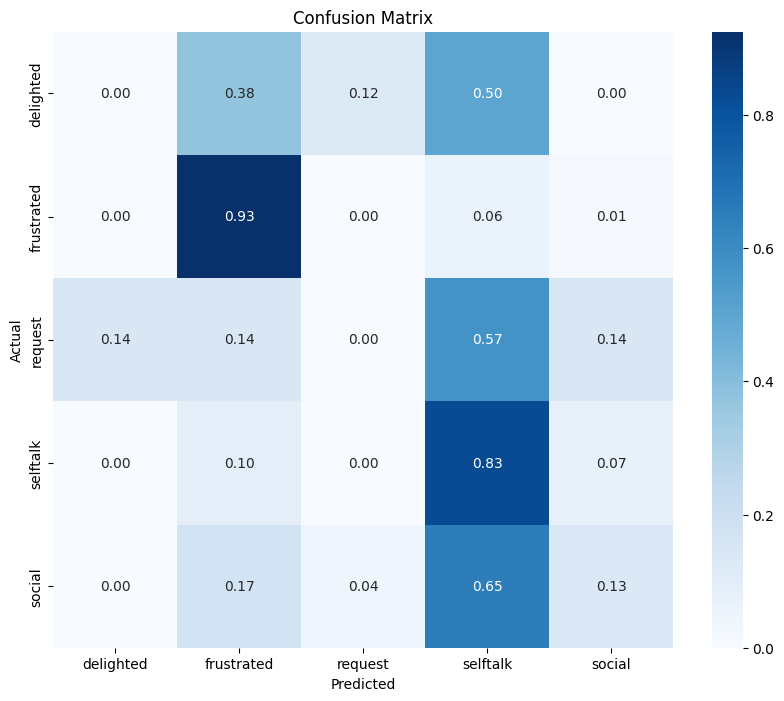

In [26]:
class_names = ['delighted', 'frustrated', 'request', 'selftalk', 'social']
plot_confusion_matrix(myModel, val_dl, class_names)